In [2]:
cd ../

/Users/seungmi/workspace/studying/bigcon_mmmz/mmmz


# Import Libraries

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import pickle
import datetime

from engine.utils import *
from engine.vars import *
from engine.predict import *

In [4]:
cd engine

/Users/seungmi/workspace/studying/bigcon_mmmz/mmmz/engine


# Load Data

In [13]:
df_wd_lag = load_df(FEATURED_DATA_DIR + '/train_fin_wd_lag.pkl')
df_wk_lag = load_df(FEATURED_DATA_DIR + '/train_fin_wk_lag.pkl')
df_all_lag = load_df(FEATURED_DATA_DIR + '/train_fin_light_ver.pkl')

# Preprocessed datasets
df_wk_lag_PP = run_preprocess(df_wk_lag)
df_wd_lag_PP = run_preprocess(df_wd_lag)

# Divide data
# WD
_, _, val_wd_lag_x, val_wd_lag_y = divide_train_val(df_wd_lag_PP, 8, drop=[])
_, _, _, top_v_wd_lag_x, top_v_wd_lag_y = divide_top(df_wd_lag_PP, 4004, 2013)
# WK
_, _, val_wk_lag_x, val_wk_lag_y = divide_train_val(df_wk_lag_PP, 8, drop=[])
_, _, _, top_v_wk_lag_x, top_v_wk_lag_y = divide_top(df_wk_lag_PP, 2206, 999)

In [14]:
top_v_wd_lag_x.shape

(2013, 75)

In [15]:
model_path = MODELS_DIR + 'lgbm_finalmodel_wd_all.bin'
model_wd_all = pickle.load(open(model_path, 'rb'))

model_path = MODELS_DIR + 'lgbm_finalmodel_wd_top.bin'
model_wd_top = pickle.load(open(model_path, 'rb'))

model_path = MODELS_DIR + 'lgbm_finalmodel_wk_all.bin'
model_wk_all = pickle.load(open(model_path, 'rb'))

model_path = MODELS_DIR + 'lgbm_finalmodel_wk_top.bin'
model_wk_top = pickle.load(open(model_path, 'rb'))

In [70]:
val_df = pd.DataFrame({"wd_true":val_wd_lag_y, "wk_true":val_wk_lag_y})
val_wd_sort = val_wd_lag_x.sort_values('mean_sales_origin', ascending=False)
# Predict all observations
pred_val_wd_all = model_wd_all.predict(val_wd_lag_x)
# Mixed DF (Top: 727개)
val_mixed_wd = mixed_df(model_wd_top, val_wd_sort, val_wd_lag_x, pred_val_wd_all, num_top=727)
val_df['wd_predicted'] = val_mixed_wd[TARGET]

val_wk_sort = val_wk_lag_x.sort_values('mean_sales_origin', ascending=False)
# Predict all observations
pred_val_wk_all = model_wk_all.predict(val_wk_lag_x)
# Mixed DF (Top: 727개)
val_mixed_wk = mixed_df(model_wk_top, val_wk_sort, val_wk_lag_x, pred_val_wk_all, num_top=249)
val_df['wk_predicted'] = val_mixed_wk[TARGET]

# val_df.reset_index(drop = True, inplace = True)

In [71]:
val_df.tail()

,wd_true,wk_true,wd_predicted,wk_predicted
25314,10157000.0,NaN,1.156714e+07,NaN
25315,50929000.0,NaN,6.557361e+06,NaN
25316,13765000.0,NaN,6.557361e+06,NaN
25317,104392000.0,NaN,7.060548e+06,NaN
25318,46608000.0,NaN,7.060548e+06,NaN


# Weekend case

## How good are the model's predictions?

In [72]:
df_wk = val_df[['wk_true', 'wk_predicted']]
df_wk.dropna(inplace = True)

# Calculate the difference between the predicted and the actual price
df_wk['diff'] = df_wk['wk_predicted'] - df_wk['wk_true']

# Calculate the absolute difference between the predicted and the actual price
df_wk['abs_diff'] = np.abs(df_wk['diff'])

# Calculate the percentage of the difference from the actual price
df_wk['%diff'] = 100 * (df_wk['diff'] / df_wk['wk_true'])

# Calculate the absolute percentage difference from the actual price
df_wk['abs_%diff'] = np.abs(df_wk['%diff'])

Text(0, 0.5, 'Diff')

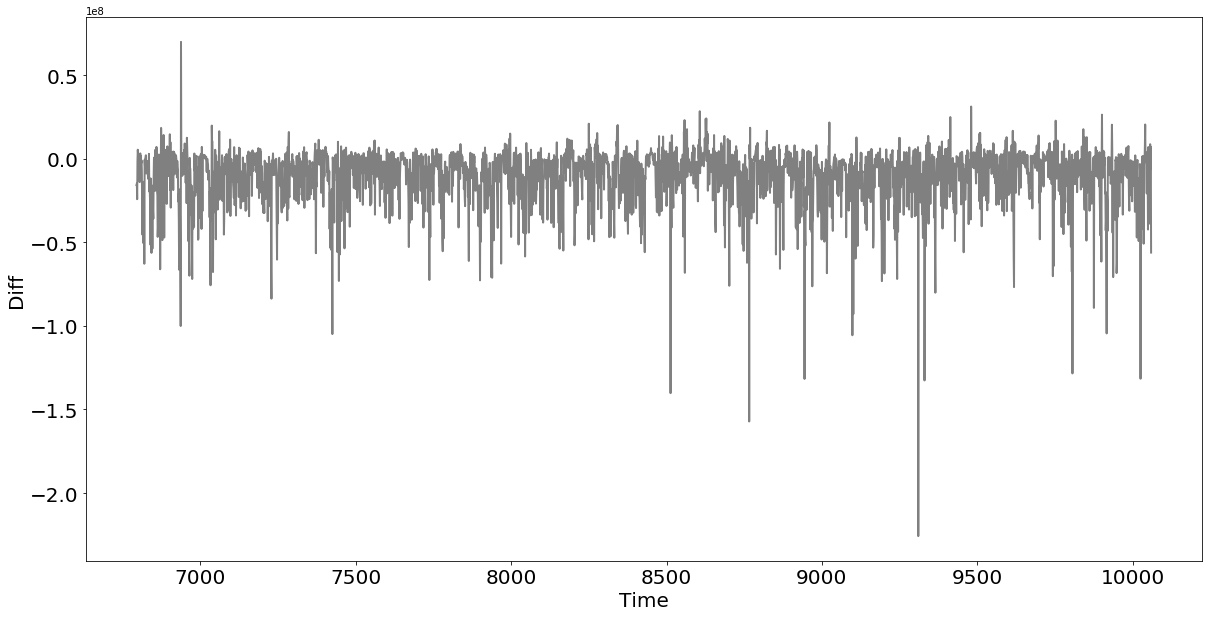

In [73]:
plt.figure(figsize=(20,10))
plt.plot(df_wk['diff'], color='grey', linewidth=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in absolute values?

In [185]:
n = 30
# Sort by the 'abs_diff' field and show the n largest mistakes in absolute values
top_missed_wk = df_wk.sort_values("abs_diff", ascending=False).head(n).index
df_wk.sort_values("abs_diff", ascending=False).head(n)

,wk_true,wk_predicted,diff,abs_diff,%diff,abs_%diff
9310,322009000.0,9.623927e+07,-2.257697e+08,2.257697e+08,-70.112865,70.112865
8766,199541000.0,4.233174e+07,-1.572093e+08,1.572093e+08,-78.785444,78.785444
8513,228177000.0,8.790224e+07,-1.402748e+08,1.402748e+08,-61.476292,61.476292
9330,153084000.0,2.040524e+07,-1.326788e+08,1.326788e+08,-86.670560,86.670560
8944,169907000.0,3.815006e+07,-1.317569e+08,1.317569e+08,-77.546503,77.546503
10025,167261000.0,3.561226e+07,-1.316487e+08,1.316487e+08,-78.708570,78.708570
9806,223492000.0,9.501380e+07,-1.284782e+08,1.284782e+08,-57.486711,57.486711
9098,119573000.0,1.392504e+07,-1.056480e+08,1.056480e+08,-88.354361,88.354361
7425,131176000.0,2.624627e+07,-1.049297e+08,1.049297e+08,-79.991562,79.991562
9916,128382000.0,2.384420e+07,-1.045378e+08,1.045378e+08,-81.427144,81.427144


In [214]:
wk_over_mcode = df_wk_lag.loc[top_missed_wk,['마더코드']]
pd.concat([df_wk_lag.loc[top_missed_wk,['방송일시','마더코드','상품코드','상품명','판매단가','취급액']], 
           df_wk.sort_values("abs_diff", ascending=False).head(n)[['wk_predicted', 'diff', '%diff']]], axis = 1)

,방송일시,마더코드,상품코드,상품명,판매단가,취급액,wk_predicted,diff,%diff
9310,2019-12-07 01:40:00,100418,201322,코몽트 덤블 플리스 자켓 2종,39900.0,322009000.0,9.623927e+07,-2.257697e+08,-70.112865
8766,2019-11-10 17:00:00,100253,200864,안동간고등어 20팩,30900.0,199541000.0,4.233174e+07,-1.572093e+08,-78.785444
8513,2019-11-02 17:40:00,100849,202513,멋진밥상 흥양농협 햅쌀 20kg,58900.0,228177000.0,8.790224e+07,-1.402748e+08,-61.476292
9330,2019-12-07 11:00:00,100288,200921,히트융 극세사 퍼융기모 남성 동내의 패키지,69900.0,153084000.0,2.040524e+07,-1.326788e+08,-86.670560
8944,2019-11-17 15:40:00,100091,200248,(1등급)221L_딤채김치냉장고,899000.0,169907000.0,3.815006e+07,-1.317569e+08,-77.546503
10025,2019-12-29 16:00:00,100724,202115,IH 옛 가마솥 세트,62000.0,167261000.0,3.561226e+07,-1.316487e+08,-78.708570
9806,2019-12-21 17:40:00,100418,201322,코몽트 덤블 플리스 자켓 2종,39900.0,223492000.0,9.501380e+07,-1.284782e+08,-57.486711
9098,2019-11-24 17:00:00,100837,202467,무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),218000.0,119573000.0,1.392504e+07,-1.056480e+08,-88.354361
7425,2019-09-22 10:40:00,100753,202202,아가타 골든 마스터 2종 (펌프스1종+플랫슈즈1종),59900.0,131176000.0,2.624627e+07,-1.049297e+08,-79.991562
9916,2019-12-28 09:00:00,100264,200878,셀렉프로 뚝배기 전기밥솥(멀티쿠커),79000.0,128382000.0,2.384420e+07,-1.045378e+08,-81.427144


In [187]:
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df_wk['diff'].mean(), df_wk['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

The mean is very close to 0 (-10417900.71) with std. 17004688.66.


Text(0, 0.5, 'Diff')

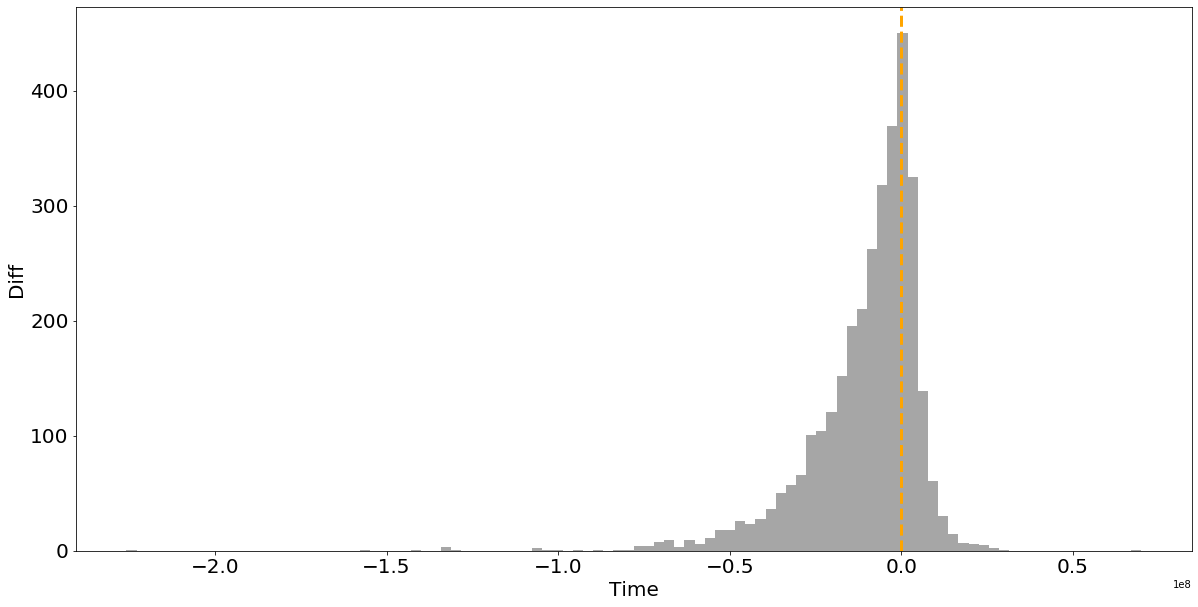

In [188]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df_wk['diff'], color='grey', bins = 100, alpha = 0.7)
plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in percentage?

In [189]:
# Sort by the '%diff' field and show the ㅜ largest proportional mistakes
top_missedp_wk = df_wk.sort_values("abs_%diff", ascending=False).head(n).index
df_wk.sort_values("abs_%diff", ascending=False).head(n)

,wk_true,wk_predicted,diff,abs_diff,%diff,abs_%diff
9413,426000.0,2.528407e+07,2.485807e+07,2.485807e+07,5835.228233,5835.228233
9756,607000.0,1.067556e+07,1.006856e+07,1.006856e+07,1658.740529,1658.740529
8628,1671000.0,2.566703e+07,2.399603e+07,2.399603e+07,1436.028290,1436.028290
8626,1831000.0,2.566703e+07,2.383603e+07,2.383603e+07,1301.804081,1301.804081
6938,5784000.0,7.558536e+07,6.980136e+07,6.980136e+07,1206.800759,1206.800759
9846,1203000.0,1.385477e+07,1.265177e+07,1.265177e+07,1051.685014,1051.685014
7645,319000.0,3.560214e+06,3.241214e+06,3.241214e+06,1016.054524,1016.054524
9758,1102000.0,1.187654e+07,1.077454e+07,1.077454e+07,977.725526,977.725526
6902,1531000.0,1.608686e+07,1.455586e+07,1.455586e+07,950.741673,950.741673
8277,1908000.0,1.720881e+07,1.530081e+07,1.530081e+07,801.929429,801.929429


In [213]:
wk_under_mcode = df_wk_lag.loc[top_missedp_wk,['마더코드']]
pd.concat([df_wk_lag.loc[top_missedp_wk,['방송일시','마더코드','상품코드','상품명','판매단가','취급액']], 
           df_wk.sort_values("abs_%diff", ascending=False).head(n)[['wk_predicted', 'diff', 'abs_%diff']]], axis = 1)

,방송일시,마더코드,상품코드,상품명,판매단가,취급액,wk_predicted,diff,abs_%diff
9413,2019-12-08 01:40:00,100197,200665,오델로 남성 겨울모자 3종,29800.0,426000.0,2.528407e+07,2.485807e+07,5835.228233
9756,2019-12-21 01:40:00,100613,201874,푸마 드라이셀 쉐이핑 레깅스 3종,59000.0,607000.0,1.067556e+07,1.006856e+07,1658.740529
8628,2019-11-03 22:40:00,100501,201517,일시불 1+1 국내제조 노비타 뉴스파 비데 무료설치,418000.0,1671000.0,2.566703e+07,2.399603e+07,1436.028290
8626,2019-11-03 22:40:00,100501,201515,무이자 1+1 국내제조 노비타 뉴스파 비데 무료설치,458000.0,1831000.0,2.566703e+07,2.383603e+07,1301.804081
6938,2019-09-07 10:40:00,100492,201487,피시원 국내산 절단 햇 꽃게 7팩,49900.0,5784000.0,7.558536e+07,6.980136e+07,1206.800759
9846,2019-12-22 11:20:00,100063,200153,대동모피 패션밍크 후드 롱코트 (19FW),690000.0,1203000.0,1.385477e+07,1.265177e+07,1051.685014
7645,2019-09-29 10:00:00,100128,200337,뱅뱅 남성 구스다운 2종,89000.0,319000.0,3.560214e+06,3.241214e+06,1016.054524
9758,2019-12-21 02:00:00,100613,201874,푸마 드라이셀 쉐이핑 레깅스 3종,59000.0,1102000.0,1.187654e+07,1.077454e+07,977.725526
6902,2019-09-01 23:20:00,100471,201438,캐치온 수퍼나인 블랙박스(1CH),99000.0,1531000.0,1.608686e+07,1.455586e+07,950.741673
8277,2019-10-20 22:40:00,100501,201515,무이자 1+1 국내제조 노비타 뉴스파 비데 무료설치,458000.0,1908000.0,1.720881e+07,1.530081e+07,801.929429


Text(0, 0.5, 'Diff')

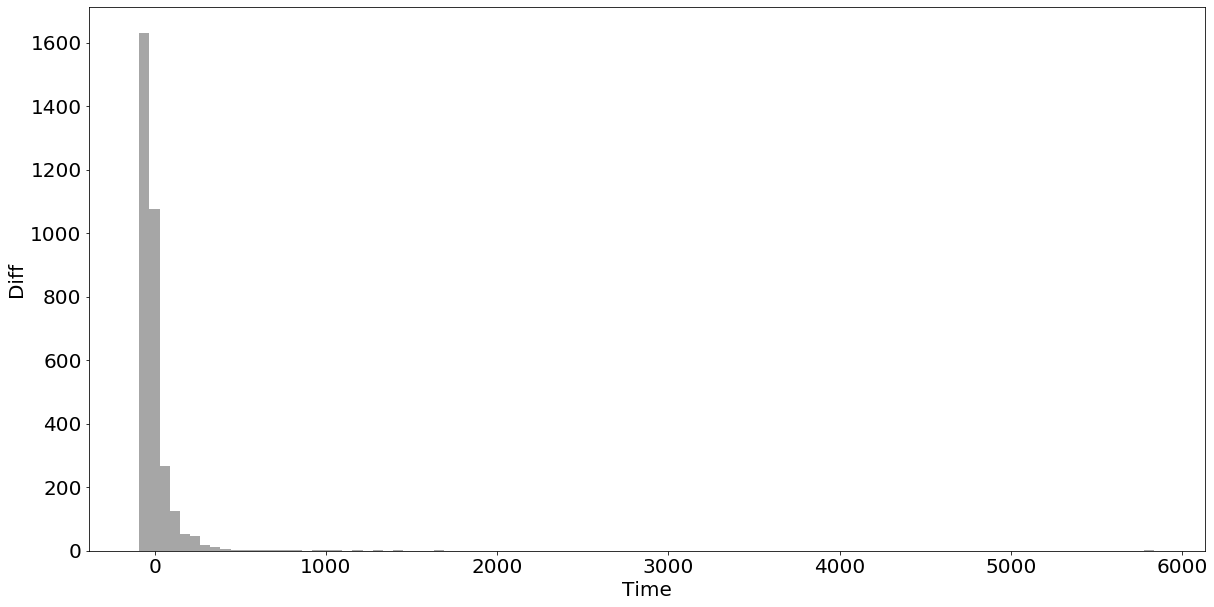

In [191]:
# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df_wk['%diff'], color='grey', bins = 100, alpha = 0.7)
# plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## items(mcode) both over/underestimated 

In [222]:
wk_under_mcode.loc[wk_under_mcode.마더코드.isin(wk_over_mcode.마더코드)].마더코드.unique()

array(['100501', '100492', '100063', '100837', '100372'], dtype=object)

비데: 파격가/기본 구성으로는 상위 매출 때려버리는데 1+1 붙으면 sales 훅 떨어져서 우리가 상향예측하게 되는 경우 발생 <br/>
꽃게: 약간 9월부터 sales가 (햇꽃게) 올라가기도 하는데 primetime 영향이 커 보임. 5월에는 프라임이어도 잘 매출이 안나와<br/>
밍크 롱코트: 이거 10분 단위 방송이라 매출 fluctuation이 너무 심해 10분안에 주문 못하면 다음 타임에 카운트가 들어가니까<br/>
밥솥: 10인용이 매출이 무조건 더 높음<br/>
온수매트: '점보특대형'이 오히려 많이 팔리고 싱글이 인기가 없네<br/>

In [256]:
y = df_wk_lag.loc[df_wk_lag.마더코드.isin(['100372'])][['상품명', '판매단가','취급액','방송일시']]
y.sort_values(['취급액'], ascending = False).head(10)

,상품명,판매단가,취급액,방송일시
9365,(퀸+퀸)일월 품안애 온수매트,248000.0,93395000.0,2019-12-07 16:00:00
9364,(퀸+싱글)일월 품안애 온수매트,218000.0,74161000.0,2019-12-07 16:00:00
7609,(점보특대형)일월 온수 카페트매트,298000.0,48175000.0,2019-09-28 21:00:00
9362,(싱글+싱글)일월 품안애 온수매트,198000.0,47514000.0,2019-12-07 16:00:00
9448,(퀸+퀸)일월 품안애 온수매트,248000.0,40437000.0,2019-12-08 11:00:00
8080,(점보특대형)일월 에너지세이브 카페트매트,198000.0,36915000.0,2019-10-13 21:20:00
8713,(점보특대형)일월 에너지세이브 카페트매트,198000.0,36354000.0,2019-11-09 23:00:00
8360,(점보특대형)일월 에너지세이브 카페트매트,198000.0,33120000.0,2019-10-26 22:00:00
8083,(점보특대형)일월 에너지세이브 카페트매트,198000.0,32923000.0,2019-10-13 21:40:00
8081,(점보형)일월 에너지세이브 카페트매트,178000.0,31778000.0,2019-10-13 21:20:00


In [257]:
y.sort_values(['취급액'], ascending = False).tail(10)

,상품명,판매단가,취급액,방송일시
7605,(중형)일월 온수 카페트매트,198000.0,1934000.0,2019-09-28 20:20:00
9355,(킹사이즈)일월 품안애 온수매트,168000.0,1845000.0,2019-12-07 15:20:00
9482,(싱글사이즈)일월 품안애 온수매트,118000.0,1753000.0,2019-12-08 17:20:00
9715,(싱글사이즈)일월 품안애 온수매트,118000.0,1705000.0,2019-12-15 17:20:00
9485,(퀸사이즈)일월 품안애 온수매트,148000.0,1620000.0,2019-12-08 17:20:00
9481,(싱글+싱글)일월 품안애 온수매트,198000.0,1381000.0,2019-12-08 17:20:00
9630,(킹사이즈)일월 품안애 온수매트,168000.0,1282000.0,2019-12-14 22:20:00
9980,(킹사이즈)일월 품안애 온수매트,168000.0,1282000.0,2019-12-28 21:40:00
9175,(킹사이즈)일월 품안애 온수매트,168000.0,1156000.0,2019-11-30 18:20:00
7604,(점보형)일월 온수 카페트매트,278000.0,850000.0,2019-09-28 20:20:00


# Weekday Case

## How good are the model's predictions?

In [192]:
df_wd = val_df[['wd_true', 'wd_predicted']]
df_wd.dropna(inplace = True)

# Calculate the difference between the predicted and the actual price
df_wd['diff'] = df_wd['wd_predicted'] - df_wd['wd_true']

# Calculate the absolute difference between the predicted and the actual price
df_wd['abs_diff'] = np.abs(df_wd['diff'])

# Calculate the percentage of the difference from the actual price
df_wd['%diff'] = 100 * (df_wd['diff'] / df_wd['wd_true'])

# Calculate the absolute percentage difference from the actual price
df_wd['abs_%diff'] = np.abs(df_wd['%diff'])

Text(0, 0.5, 'Diff')

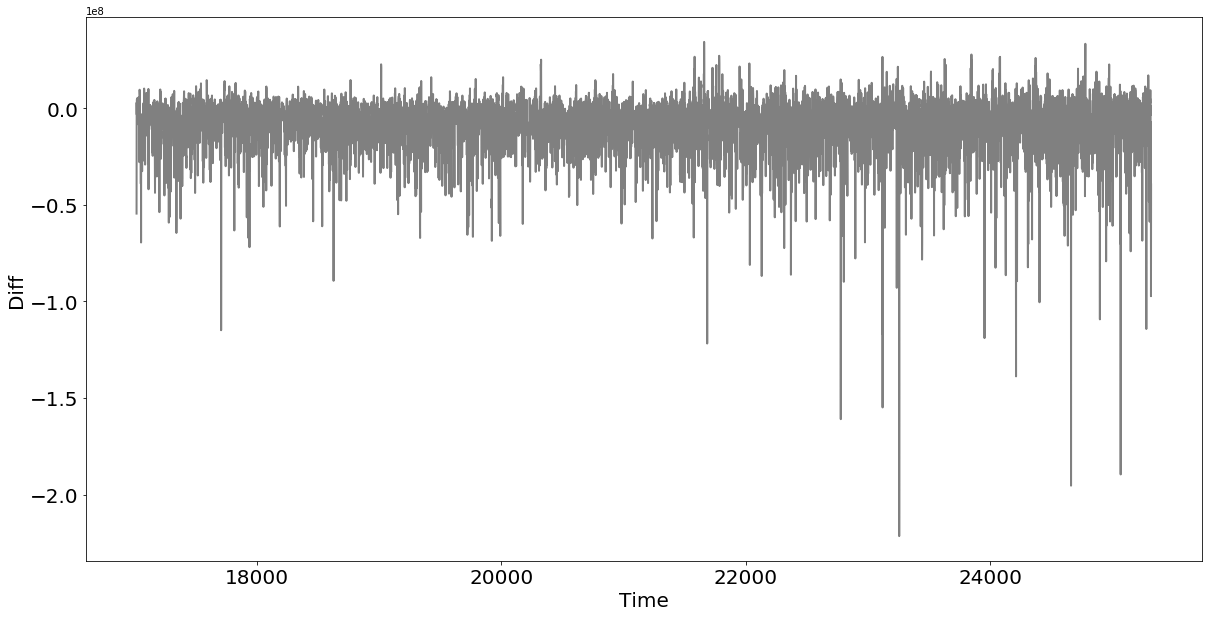

In [193]:
plt.figure(figsize=(20,10))
plt.plot(df_wd['diff'], color='grey', linewidth=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in absolute values?

In [194]:
# Sort by the 'abs_diff' field and show the n largest mistakes in absolute values
top_missed_wd = df_wd.sort_values("abs_diff", ascending=False).head(n).index
df_wd.sort_values("abs_diff", ascending=False).head(n)

,wd_true,wd_predicted,diff,abs_diff,%diff,abs_%diff
23257,231789000.0,1.033705e+07,-2.214519e+08,2.214519e+08,-95.540318,95.540318
24663,216065000.0,2.070948e+07,-1.953555e+08,1.953555e+08,-90.415163,90.415163
25069,270284000.0,8.073139e+07,-1.895526e+08,1.895526e+08,-70.130901,70.130901
22779,241079000.0,8.011949e+07,-1.609595e+08,1.609595e+08,-66.766292,66.766292
23121,225084000.0,7.019243e+07,-1.548916e+08,1.548916e+08,-68.815007,68.815007
23258,157780000.0,9.815981e+06,-1.479640e+08,1.479640e+08,-93.778691,93.778691
24213,152770000.0,1.395721e+07,-1.388128e+08,1.388128e+08,-90.863904,90.863904
21686,135711000.0,1.389507e+07,-1.218159e+08,1.218159e+08,-89.761276,89.761276
23955,187419000.0,6.841503e+07,-1.190040e+08,1.190040e+08,-63.496217,63.496217
23117,185927000.0,6.932475e+07,-1.166022e+08,1.166022e+08,-62.713994,62.713994


In [261]:
wd_under_mcode = df_wd_lag.loc[top_missed_wd,['마더코드']]
pd.concat([df_wd_lag.loc[top_missed_wd,['방송일시','마더코드','상품코드','상품명','판매단가','취급액']], 
           df_wd.sort_values("abs_diff", ascending=False).head(n)[['wd_predicted', 'diff', '%diff']]], axis = 1)

,방송일시,마더코드,상품코드,상품명,판매단가,취급액,wd_predicted,diff,%diff
23257,2019-11-29 23:00:00,100148,200412,LG 울트라HD TV 65UM7900BNA,1700000.0,231789000.0,1.033705e+07,-2.214519e+08,-95.540318
24663,2019-12-20 14:00:00,100558,201655,정직한 농부의 석류,59900.0,216065000.0,2.070948e+07,-1.953555e+08,-90.415163
25069,2019-12-27 00:00:00,100323,201025,피시원 국내산 햇 손질문어 7팩,49900.0,270284000.0,8.073139e+07,-1.895526e+08,-70.130901
22779,2019-11-22 19:00:00,100317,201665,국내산 손질 햇 갑오징어 9팩,49900.0,241079000.0,8.011949e+07,-1.609595e+08,-66.766292
23121,2019-11-28 16:20:00,100255,200869,한일 대용량 스텐 분쇄믹서기,109800.0,225084000.0,7.019243e+07,-1.548916e+08,-68.815007
23258,2019-11-29 23:00:00,100148,200413,LG 울트라HD TV 75UM7900BNA,2840000.0,157780000.0,9.815981e+06,-1.479640e+08,-93.778691
24213,2019-12-13 22:00:00,100155,200556,일시불 LG전자 매직스페이스 냉장고,1359000.0,152770000.0,1.395721e+07,-1.388128e+08,-90.863904
21686,2019-11-07 00:00:00,100340,201057,스튜디오럭스 후드롱구스다운코트,59000.0,135711000.0,1.389507e+07,-1.218159e+08,-89.761276
23955,2019-12-11 00:00:00,100418,201322,코몽트 덤블 플리스 자켓 2종,39900.0,187419000.0,6.841503e+07,-1.190040e+08,-63.496217
23117,2019-11-28 15:00:00,100766,202239,참존 탑뉴스 지이링클 기초세트,59000.0,185927000.0,6.932475e+07,-1.166022e+08,-62.713994


In [196]:
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df_wd['diff'].mean(), df_wd['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

The mean is very close to 0 (-8399428.65) with std. 14336210.92.


Text(0, 0.5, 'Diff')

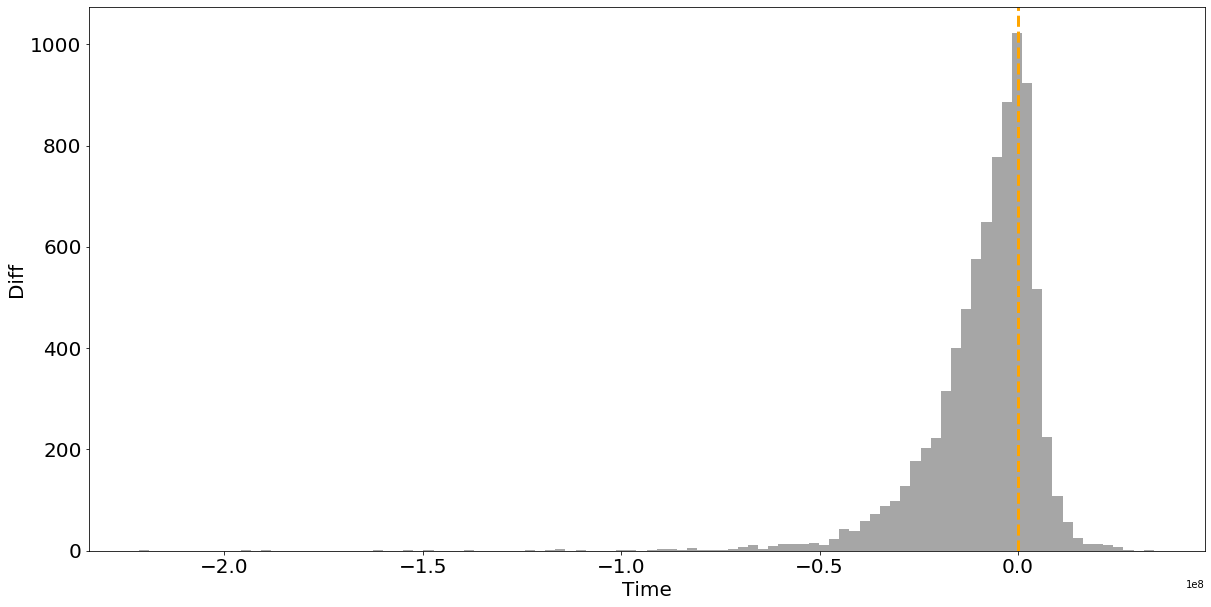

In [197]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df_wd['diff'], color='grey', bins = 100, alpha = 0.7)
plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## What is the biggest difference in percentage?

In [198]:
# Sort by the '%diff' field and show the ㅜ largest proportional mistakes
top_missedp_wd = df_wd.sort_values("abs_%diff", ascending=False).head(n).index
df_wd.sort_values("abs_%diff", ascending=False).head(n)

,wd_true,wd_predicted,diff,abs_diff,%diff,abs_%diff
24463,179000.0,9.271604e+06,9.092604e+06,9.092604e+06,5079.666827,5079.666827
24461,308000.0,1.078847e+07,1.048047e+07,1.048047e+07,3402.750950,3402.750950
20284,181000.0,5.265937e+06,5.084937e+06,5.084937e+06,2809.357309,2809.357309
20286,443000.0,1.062200e+07,1.017900e+07,1.017900e+07,2297.742434,2297.742434
21898,181000.0,3.552108e+06,3.371108e+06,3.371108e+06,1862.490653,1862.490653
19210,400000.0,7.069739e+06,6.669739e+06,6.669739e+06,1667.434840,1667.434840
23842,1332000.0,2.192124e+07,2.058924e+07,2.058924e+07,1545.738795,1545.738795
23012,840000.0,1.264481e+07,1.180481e+07,1.180481e+07,1405.334023,1405.334023
21761,1671000.0,2.395907e+07,2.228807e+07,2.228807e+07,1333.816246,1333.816246
24459,308000.0,4.234458e+06,3.926458e+06,3.926458e+06,1274.824187,1274.824187


In [258]:
wd_over_mcode = df_wd_lag.loc[top_missedp_wd,['마더코드']]
pd.concat([df_wd_lag.loc[top_missedp_wd,['방송일시','마더코드','상품코드','상품명','판매단가','취급액']], 
           df_wd.sort_values("abs_%diff", ascending=False).head(n)[['wd_predicted', 'diff', 'abs_%diff']]], axis = 1)

,방송일시,마더코드,상품코드,상품명,판매단가,취급액,wd_predicted,diff,abs_%diff
24463,2019-12-18 14:00:00,100395,201272,1세트 센티멘탈 디퓨저골드,31000.0,179000.0,9.271604e+06,9.092604e+06,5079.666827
24461,2019-12-18 13:40:00,100395,201272,1세트 센티멘탈 디퓨저골드,31000.0,308000.0,1.078847e+07,1.048047e+07,3402.750950
20284,2019-10-16 23:00:00,100395,201272,1세트 센티멘탈 디퓨저골드,31000.0,181000.0,5.265937e+06,5.084937e+06,2809.357309
20286,2019-10-16 23:20:00,100395,201272,1세트 센티멘탈 디퓨저골드,31000.0,443000.0,1.062200e+07,1.017900e+07,2297.742434
21898,2019-11-11 01:20:00,100395,201272,1세트 센티멘탈 디퓨저골드,31000.0,181000.0,3.552108e+06,3.371108e+06,1862.490653
19210,2019-10-02 12:00:00,100240,200816,키친아트 스마트뷰 스텐밀폐용기 9종,89000.0,400000.0,7.069739e+06,6.669739e+06,1667.434840
23842,2019-12-09 23:20:00,100043,200118,알렉스하운드 양모 퀼팅 패딩 자켓,29900.0,1332000.0,2.192124e+07,2.058924e+07,1545.738795
23012,2019-11-27 12:40:00,100837,202470,무이자 쿠쿠전기밥솥 6인용(QS),208000.0,840000.0,1.264481e+07,1.180481e+07,1405.334023
21761,2019-11-07 19:40:00,100501,201517,일시불 1+1 국내제조 노비타 뉴스파 비데 무료설치,418000.0,1671000.0,2.395907e+07,2.228807e+07,1333.816246
24459,2019-12-18 13:20:00,100395,201272,1세트 센티멘탈 디퓨저골드,31000.0,308000.0,4.234458e+06,3.926458e+06,1274.824187


### 상향예측 나오는 이유?
디퓨저골드 같은 경우 같은 마더코드 공유하는 5세트 제품이 취급액이 높음<br/>
우리 모델로는 5세트와 1세트간에 features 차이가 판매단가말고는 없어서 detect가 안되는 듯

In [275]:
df_wd_lag[df_wd_lag.마더코드 == "100395"][['상품코드','방송일시','상품명','original_c','판매단가','취급액']].head(6)

,상품코드,방송일시,상품명,original_c,판매단가,취급액
20284,201272,2019-10-16 23:00:00,1세트 센티멘탈 디퓨저골드,다퓨저,31000.0,181000.0
20285,201278,2019-10-16 23:00:00,5세트 센티멘탈 디퓨저골드패키지,다퓨저,69000.0,23923000.0
20286,201272,2019-10-16 23:20:00,1세트 센티멘탈 디퓨저골드,다퓨저,31000.0,443000.0
20287,201278,2019-10-16 23:20:00,5세트 센티멘탈 디퓨저골드패키지,다퓨저,69000.0,23506000.0
20288,201278,2019-10-16 23:40:00,5세트 센티멘탈 디퓨저골드패키지,다퓨저,69000.0,31327000.0
21898,201272,2019-11-11 01:20:00,1세트 센티멘탈 디퓨저골드,다퓨저,31000.0,181000.0


Text(0, 0.5, 'Diff')

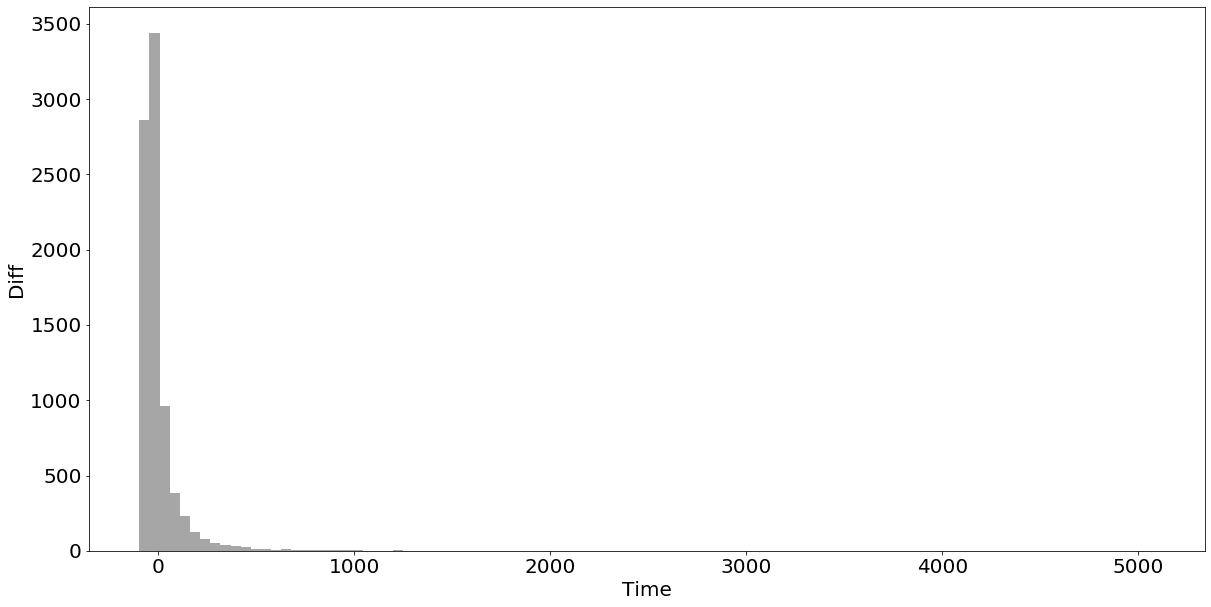

In [200]:
# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df_wd['%diff'], color='grey', bins = 100, alpha = 0.7)
# plt.axvline(x=0, color = "orange", linewidth = 3, linestyle='dashed')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Diff', fontsize=20)

## items(mcode) both over/underestimated 

In [262]:
wd_under_mcode.loc[wd_under_mcode.마더코드.isin(wd_over_mcode.마더코드)].마더코드.unique()

array(['100448', '100091'], dtype=object)

밥솥: 10인용이 매출이 무조건 더 높음<br/>
김치냉장고: 영문을 모르겠다<br/>

In [268]:
y = df_wk_lag.loc[df_wk_lag.마더코드.isin(['100091'])][['상품명', '판매단가','취급액','방송일시']]
y.sort_values(['취급액'], ascending = False).head(10)

,상품명,판매단가,취급액,방송일시
8944,(1등급)221L_딤채김치냉장고,899000.0,169907000.0,2019-11-17 15:40:00
8559,(1등급)467L_딤채김치냉장고,2549000.0,106446000.0,2019-11-03 09:50:00
9165,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000.0,86695000.0,2019-11-30 16:20:00
8688,(1등급)221L_딤채김치냉장고,899000.0,84844000.0,2019-11-09 14:00:00
9166,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000.0,67485000.0,2019-11-30 16:40:00
8687,(1등급)221L_딤채김치냉장고,899000.0,65071000.0,2019-11-09 13:40:00
8706,(1등급)467L_딤채김치냉장고,2549000.0,64150000.0,2019-11-09 21:50:00
8770,(1등급)467L_딤채김치냉장고,2549000.0,50477000.0,2019-11-10 17:50:00
9164,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000.0,44709000.0,2019-11-30 16:00:00
8943,(1등급)221L_딤채김치냉장고,899000.0,40313000.0,2019-11-17 15:20:00


In [266]:
y.sort_values(['취급액'], ascending = False).tail(10)

,상품명,판매단가,취급액,방송일시
9163,(1등급)221L_딤채김치냉장고(LDL22DHWJJ),899000.0,25232000.0,2019-11-30 15:40:00
8557,(1등급)467L_딤채김치냉장고,2549000.0,21845000.0,2019-11-03 09:20:00
8768,(1등급)467L_딤채김치냉장고,2549000.0,21418000.0,2019-11-10 17:20:00
8704,(1등급)467L_딤채김치냉장고,2549000.0,20987000.0,2019-11-09 21:20:00
8769,(1등급)221L_딤채김치냉장고,899000.0,19681000.0,2019-11-10 17:50:00
8558,(1등급)221L_딤채김치냉장고,899000.0,15134000.0,2019-11-03 09:50:00
8767,(1등급)221L_딤채김치냉장고,899000.0,12717000.0,2019-11-10 17:20:00
8703,(1등급)221L_딤채김치냉장고,899000.0,10151000.0,2019-11-09 21:20:00
8686,(1등급)221L_딤채김치냉장고,899000.0,7445000.0,2019-11-09 13:20:00
8556,(1등급)221L_딤채김치냉장고,899000.0,5028000.0,2019-11-03 09:20:00


# Then, what makes us to predict wrong?

In [201]:
num_cols = ['판매단가', '취급액',
       'months','parttime', 'min_range','primetime', 'freq',
       'dup_times', 'dup_times_smallc',
       'bpower', 'steady','luxury', 'pay',
       'summer', 'fall', 'winter', 'rain', 'temp_diff_s', 
       'mean_sales_origin']
cat_cols = ['상품군','big_c','middle_c','small_c','original_c']

In [202]:
# 전체 wk
df_wk_lag[num_cols].describe() #.iloc[~df_wk_lag.index.isin(top_missed_wk)]

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,1.006000e+04,1.006000e+04,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,10060.000000,1.006000e+04
mean,4.503309e+05,2.581054e+07,6.466899,0.506759,0.689165,3.087972,1.306362,0.336183,0.531710,0.259940,0.231412,0.099006,0.358449,0.074652,9.209473,2.331392e+07
std,6.798072e+05,2.302324e+07,3.393414,0.786514,0.462858,1.703407,0.711612,0.472426,0.499018,0.438623,0.421756,0.298685,0.479569,0.262842,3.037940,1.398198e+07
min,2.900000e+04,2.680000e+05,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.300000,2.372600e+06
25%,5.990000e+04,8.555250e+06,3.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.900000,1.232607e+07
50%,1.190000e+05,1.851500e+07,6.000000,0.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.400000,1.841857e+07
75%,5.090000e+05,3.671600e+07,9.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,11.000000,3.123914e+07
max,5.060000e+06,3.220090e+08,12.000000,2.000000,1.000000,9.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.400000,1.172547e+08


In [203]:
df_wk_lag.iloc[top_missed_wk][num_cols].describe() #하향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01
mean,1.898000e+05,1.338223e+08,10.866667,0.966667,0.533333,2.566667,1.133333,0.200000,0.866667,0.100000,0.100000,0.133333,0.466667,0.100000,7.756667,3.701977e+07
std,2.906750e+05,5.416103e+07,1.166585,0.927857,0.507416,0.935261,0.345746,0.406838,0.345746,0.305129,0.305129,0.345746,0.507416,0.305129,2.806603,1.660597e+07
min,3.090000e+04,8.350400e+07,9.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.300000,1.232607e+07
25%,5.922500e+04,9.757050e+07,10.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.525000,2.523754e+07
50%,6.990000e+04,1.097920e+08,11.000000,1.000000,1.000000,2.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.050000,3.509397e+07
75%,1.890000e+05,1.637168e+08,12.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10.000000,4.684764e+07
max,1.359000e+06,3.220090e+08,12.000000,2.000000,1.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.700000,8.149775e+07


#### 취급액이 유독 하향예측된 상품들의 공통점?
판매단가가 오히려 평균 대비 낮고, primetime 에 속함. freq/bpower 는 오히려 낮은 경향이 있고 겨울 계절상품인 경우가 많다


In [204]:
df_wk_lag.iloc[top_missedp_wk][num_cols].describe() #우리가 상향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,30.000000,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,3.000000e+01
mean,260616.666667,1.567567e+06,10.833333,0.033333,0.766667,2.800000,1.033333,0.466667,0.533333,0.100000,0.033333,0.266667,0.500000,0.0,9.090000,2.109535e+07
std,197198.977201,1.040055e+06,1.234094,0.182574,0.430183,1.648406,0.182574,0.507416,0.507416,0.305129,0.182574,0.449776,0.508548,0.0,2.933557,1.393755e+07
min,29800.000000,3.190000e+05,9.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.800000,4.626708e+06
25%,67175.000000,9.130000e+05,10.000000,0.000000,1.000000,1.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.600000,1.549914e+07
50%,203000.000000,1.486500e+06,11.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.0,9.800000,1.775068e+07
75%,434500.000000,1.661750e+06,12.000000,0.000000,1.000000,4.750000,1.000000,1.000000,1.000000,0.000000,0.000000,0.750000,1.000000,0.0,10.900000,2.127351e+07
max,690000.000000,5.784000e+06,12.000000,1.000000,1.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,13.700000,8.149775e+07


In [205]:
df_wk_lag.iloc[top_missed_wk][cat_cols].sort_values(['상품군'])

,상품군,big_c,middle_c,small_c,original_c
8944,가전,디지털/가전,주방가전,김치냉장고,김치냉장고
8969,가전,디지털/가전,주방가전,냉장고,냉장고
8766,농수축,식품,수산,생선,간고등어
8513,농수축,식품,농산물,쌀,쌀
6937,농수축,식품,수산,해산물/어패류,꽃게
9365,생활용품,디지털/가전,계절가전,전기매트,매트
9193,생활용품,생활/건강,욕실용품,비데/비데용품,비데
8702,생활용품,생활/건강,욕실용품,비데/비데용품,비데
9618,생활용품,생활/건강,욕실용품,비데/비데용품,비데
9330,속옷,패션의류,남성언더웨어/잠옷,시즌성내의,내복


In [212]:
df_wk_lag.iloc[top_missedp_wk][cat_cols].sort_values(['상품군'])

,상품군,big_c,middle_c,small_c,original_c
8181,가구,가구/인테리어,침실가구,침대,침대
7381,가구,가구/인테리어,침실가구,침대,침대
6938,농수축,식품,수산,해산물/어패류,꽃게
9591,농수축,식품,냉동/간편조리식품,즉석국/즉석탕,곰탕
8628,생활용품,생활/건강,욕실용품,비데/비데용품,비데
9406,생활용품,생활/건강,문구/사무용품,사무기기,금고
10058,생활용품,생활/건강,문구/사무용품,사무기기,금고
9980,생활용품,디지털/가전,계절가전,전기매트,매트
8271,생활용품,생활/건강,욕실용품,비데/비데용품,비데
10056,생활용품,생활/건강,문구/사무용품,사무기기,금고


In [207]:
# 전체 wd
df_wd_lag[num_cols].describe() #.iloc[~df_wd_lag.index.isin(top_missed_wd)]

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,2.531900e+04,2.531900e+04,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,25319.000000,2.531900e+04
mean,3.630370e+05,2.202639e+07,6.502390,0.347842,0.632766,2.985584,1.198191,0.270903,0.457996,0.208855,0.205735,0.103875,0.330108,0.125360,9.351420,2.301837e+07
std,6.021002e+05,1.864156e+07,3.396789,0.662003,0.482061,1.583145,0.514175,0.444435,0.498242,0.406499,0.404246,0.305104,0.470261,0.331134,2.871092,1.358430e+07
min,1.280000e+04,1.030000e+05,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.800000,1.159000e+06
25%,5.900000e+04,7.773500e+06,4.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000,1.232607e+07
50%,9.600000e+04,1.689700e+07,7.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.300000,1.848124e+07
75%,2.590000e+05,3.151050e+07,9.000000,0.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.200000,3.096592e+07
max,7.930000e+06,2.702840e+08,12.000000,2.000000,1.000000,10.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.500000,9.958071e+07


In [208]:
df_wd_lag.iloc[top_missed_wd][num_cols].describe() #하향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01
mean,8.703900e+05,1.409483e+08,11.000000,0.200000,0.700000,2.566667,1.266667,0.433333,0.866667,0.433333,0.066667,0.133333,0.666667,0.133333,9.366667,3.739777e+07
std,1.033439e+06,5.204421e+07,2.051072,0.550861,0.466092,1.104328,0.449776,0.504007,0.345746,0.504007,0.253708,0.345746,0.479463,0.345746,1.966676,1.618464e+07
min,3.990000e+04,9.167300e+07,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.500000,1.221779e+07
25%,5.900000e+04,1.012385e+08,11.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.300000,2.366859e+07
50%,1.389000e+05,1.163640e+08,11.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.600000,3.597811e+07
75%,1.499000e+06,1.656832e+08,12.000000,0.000000,1.000000,3.000000,1.750000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,10.300000,4.701464e+07
max,2.990000e+06,2.702840e+08,12.000000,2.000000,1.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.300000,6.561081e+07


#### 취급액이 유독 하향예측된 상품들의 공통점?

In [209]:
df_wd_lag.iloc[top_missedp_wd][num_cols].describe() #우리가 상향예측한 애들

,판매단가,취급액,months,primetime,freq,dup_times,dup_times_smallc,bpower,steady,luxury,summer,fall,winter,rain,temp_diff_s,mean_sales_origin
count,30.000000,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01
mean,135493.333333,9.621667e+05,11.166667,0.166667,0.200000,2.966667,1.133333,0.166667,0.166667,0.033333,0.100000,0.166667,0.366667,0.133333,8.436667,2.084505e+07
std,195044.809941,8.571835e+05,0.874281,0.379049,0.406838,1.542129,0.345746,0.379049,0.379049,0.182574,0.305129,0.379049,0.490133,0.345746,2.564813,1.663816e+07
min,29900.000000,1.790000e+05,9.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.200000,1.583000e+06
25%,31000.000000,3.272500e+05,11.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.425000,9.498000e+06
50%,42400.000000,5.325000e+05,11.000000,0.000000,0.000000,2.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.200000,1.557672e+07
75%,126500.000000,1.470500e+06,12.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.700000,2.589278e+07
max,899000.000000,3.304000e+06,12.000000,1.000000,1.000000,7.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.300000,5.548691e+07


In [210]:
df_wd_lag.iloc[top_missed_wd][cat_cols].sort_values(['상품군'])

,상품군,big_c,middle_c,small_c,original_c
23257,가전,디지털/가전,영상가전,TV,TV
24212,가전,디지털/가전,주방가전,냉장고,냉장고
24045,가전,디지털/가전,주방가전,냉장고,냉장고
23256,가전,디지털/가전,영상가전,TV,TV
24129,가전,디지털/가전,영상가전,TV,TV
22132,가전,디지털/가전,주방가전,김치냉장고,김치냉장고
24221,가전,디지털/가전,영상가전,TV,TV
24405,가전,디지털/가전,영상가전,TV,TV
23444,가전,디지털/가전,주방가전,냉장고,냉장고
23258,가전,디지털/가전,영상가전,TV,TV


In [211]:
df_wd_lag.iloc[top_missedp_wd][cat_cols].sort_values(['상품군'])

,상품군,big_c,middle_c,small_c,original_c
22324,가구,가구/인테리어,침실가구,서랍장,수납장
21784,가전,디지털/가전,주방가전,김치냉장고,김치냉장고
24463,생활용품,가구/인테리어,인테리어소품,아로마/캔들용품,다퓨저
20673,생활용품,가구/인테리어,DIY자재/용품,벽지,벽지
24018,생활용품,생활/건강,욕실용품,비데/비데용품,비데
21901,생활용품,가구/인테리어,인테리어소품,아로마/캔들용품,다퓨저
24325,생활용품,생활/건강,문구/사무용품,사무기기,금고
23971,생활용품,가구/인테리어,서재/사무용가구,의자,접이식의자
22257,생활용품,가구/인테리어,DIY자재/용품,벽지,벽지
25085,생활용품,가구/인테리어,서재/사무용가구,의자,접이식의자
